<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU9proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unit 9 Project: Predicting Student Success

##Introduction

We take a lot of tests and do a lot of assignment as student. Like, far too many. Many a students have found themselves up late at night, deciding whether to study, go to sleep, or scroll reels for another 3 hours.

In this project, I'll attempt to predict a student's test score. I want to know whether I should actually study or if it doesn't matter and watching youtube shorts is the optimal strategy for academic success. I got this data set from kaggle.

In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

##Data

In [2]:
student = pd.read_csv("https://raw.githubusercontent.com/OwenHuels/data-science/refs/heads/main/student_habits_performance.csv").dropna()

Here is my data set. There's a lot of different variables we could consider, but let's take a look at the pairplot to see which ones have the strongest relationship to exam score. Oh, and before I forget, let's limit the columns to the ones that are truly numerical.

In [3]:
student

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S1995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,S1996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,S1997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,S1998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7


In [5]:
stats = student[["exam_score","study_hours_per_day","attendance_percentage","social_media_hours","netflix_hours","sleep_hours"]]

In [6]:
stats

,exam_score,study_hours_per_day,attendance_percentage,social_media_hours,netflix_hours,sleep_hours
0,56.2,0.0,85.0,1.2,1.1,8.0
1,100.0,6.9,97.3,2.8,2.3,4.6
2,34.3,1.4,94.8,3.1,1.3,8.0
3,26.8,1.0,71.0,3.9,1.0,9.2
4,66.4,5.0,90.9,4.4,0.5,4.9
...,...,...,...,...,...,...
995,76.1,2.6,77.0,0.5,1.6,7.5
996,65.9,2.9,86.0,1.0,2.4,6.8
997,64.4,3.0,61.9,2.6,1.3,6.5
998,69.7,5.4,100.0,4.1,1.1,7.6


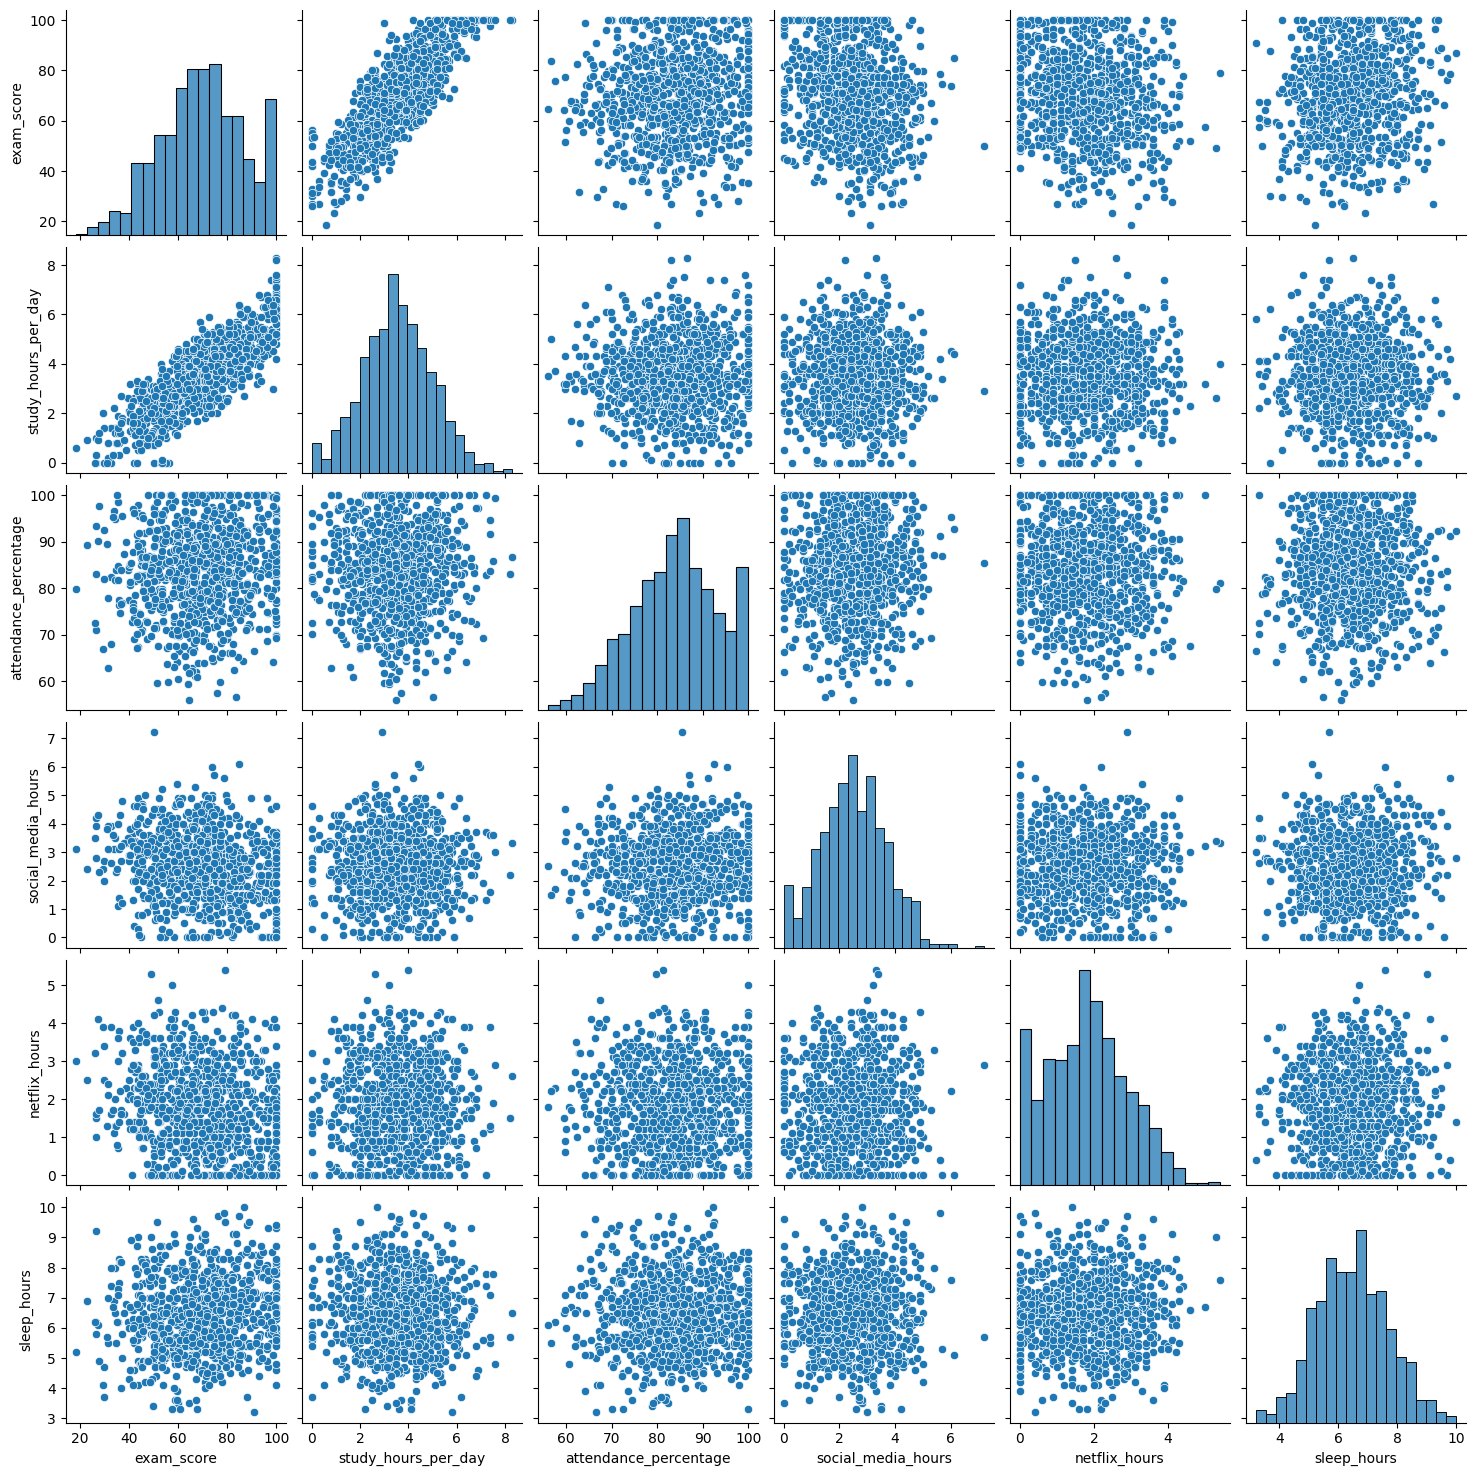

In [22]:
sns.pairplot(stats)

It seems like study hours is by far the best predictor of exam score, and the only one that's strongly linear, so let's focus on that.

In [7]:
#convert to numpy array
s_matrix = stats.to_numpy()
#convert to a PyTorch tensor
s_tensor = torch.from_numpy(s_matrix)

In [8]:
s_tensor

tensor([[ 56.2000,   0.0000,  85.0000,   1.2000,   1.1000,   8.0000],
        [100.0000,   6.9000,  97.3000,   2.8000,   2.3000,   4.6000],
        [ 34.3000,   1.4000,  94.8000,   3.1000,   1.3000,   8.0000],
        ...,
        [ 64.4000,   3.0000,  61.9000,   2.6000,   1.3000,   6.5000],
        [ 69.7000,   5.4000, 100.0000,   4.1000,   1.1000,   7.6000],
        [ 74.9000,   4.3000,  89.4000,   2.9000,   1.9000,   7.1000]],
       dtype=torch.float64)

In [9]:
#convert to a PyTorch tensor
es = stats['exam_score'].to_numpy()
score = torch.from_numpy(es)
sh = stats['study_hours_per_day'].to_numpy()
study = torch.from_numpy(sh)

X = study.unsqueeze(dim=1) #use study hours as a predictor
y = score.unsqueeze(dim=1) #exam score is the estimand, the thing we're predicting.


# Scale the height using standardization
scaler = StandardScaler()
study_scaled = scaler.fit_transform(
    study.reshape(-1, 1) #makes it a column vector
    )

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    study_scaled, score, test_size=0.2,
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

<ipython-input-9-28e8a733ce30>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
<ipython-input-9-28e8a733ce30>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


##Models

For my first model, I'll just run a straight-up, 1 to 1 linear model to see how it does as a baseline.

In [10]:
model_linear = torch.nn.Linear(
    in_features=1, # in_features: must match number of columns of input, which is now one
    out_features=1,# out_features: number of columns in output
    dtype=torch.float64) #specifies the data type

In [11]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_linear.parameters(),
                            lr=0.001) #this is how fast it optimizes; smaller is slower, but more consistent

In [12]:
# Ensure that the input data and target data are in the correct dtype (Float)
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Ensure that the model's parameters are in the correct dtype (Float)
model_linear = model_linear.float()

In [13]:
# Set the number of epochs; this is how many times we update our model
epochs = 2000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_linear.train()

    # 1. Forward pass; makes predictions
    y_pred = model_linear(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_linear.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_linear(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 100 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([182])) that is different to the input size (torch.Size([182, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 | Train loss: 5221.35449, Test loss: 4946.08789
Epoch: 100 | Train loss: 3526.56812, Test loss: 3381.32300
Epoch: 200 | Train loss: 2392.13525, Test loss: 2348.70166
Epoch: 300 | Train loss: 1632.78003, Test loss: 1669.54932
Epoch: 400 | Train loss: 1124.48877, Test loss: 1224.77209
Epoch: 500 | Train loss: 784.25037, Test loss: 935.06207
Epoch: 600 | Train loss: 556.50177, Test loss: 747.66949
Epoch: 700 | Train loss: 404.05115, Test loss: 627.55750
Epoch: 800 | Train loss: 302.00244, Test loss: 551.49609
Epoch: 900 | Train loss: 233.69197, Test loss: 504.11880
Epoch: 1000 | Train loss: 187.96555, Test loss: 475.28781
Epoch: 1100 | Train loss: 157.35608, Test loss: 458.33755
Epoch: 1200 | Train loss: 136.86606, Test loss: 448.90521
Epoch: 1300 | Train loss: 123.14988, Test loss: 444.15112
Epoch: 1400 | Train loss: 113.96822, Test loss: 442.23972
Epoch: 1500 | Train loss: 107.82190, Test loss: 441.99567
Epoch: 1600 | Train loss: 103.70754, Test loss: 442.67593
Epoch: 1700 | Tr

In [14]:
# Turn on evaluation mode
model_linear.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_linear(X_test)

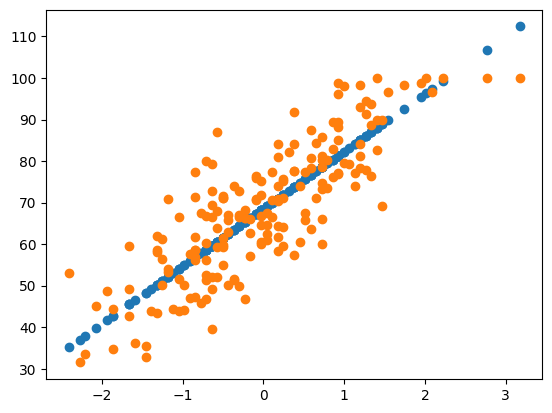

In [15]:
#plots predictions--remember, our model has never seen X_test
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

This looks like a pretty solid prediction. The data is mostly linear and our model captured that well. The only behavior that I think might be here that isn't being captured is a tapering near low and high exam score. It's impossible to score over an 100 on this exam, so the line shouldn't keep going beyond that.

I'll make the model more complex by making it non-linear and adding some more hidden layers. I think this should allow it to capture that tapering at the ends I was talking about.

In [16]:
model_nonlin = nn.Sequential(
    nn.Linear(in_features=1, out_features=5),
    nn.RReLU(),
    nn.Linear(in_features=5, out_features=5),
    nn.RReLU(),
    nn.Linear(in_features=5, out_features=5),
    nn.RReLU(),
    nn.Linear(in_features=5, out_features=1),
)

In [17]:
# Create a loss function
loss_fn = nn.MSELoss()

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=model_nonlin.parameters(),
                            lr=0.001) #this is how fast it optimizes; smaller is slower, but more consistent

In [18]:
# Ensure that the input data and target data are in the correct dtype (Float)
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()
y_test = y_test.float()

# Ensure that the model's parameters are in the correct dtype (Float)
model_linear = model_nonlin.float()

In [19]:
# Set the number of epochs; this is how many times we update our model
epochs = 2000

for epoch in range(epochs):
    ### Training

    #this allows our matrices to update
    model_nonlin.train()

    # 1. Forward pass; makes predictions
    y_pred = model_nonlin(X_train)

    # 2. Calculate loss; how bad were our predictions?
    loss = loss_fn(y_pred.squeeze(), y_train)

    # 3. Optimizer zero grad; resets how we change our model
    optimizer.zero_grad()

    # 4. Loss backwards; determines how to change our weights matrix
    loss.backward()

    # 5. Optimizer step; changes our weights matrix based on .backward()
    optimizer.step()

    ### Testing
    model_nonlin.eval() #forces our matrices to stay the same
    with torch.inference_mode():
      # 1. Forward pass; makes predictions, but with test data
      test_pred = model_nonlin(X_test)
      # 2. Calculate the loss, but with test data
      test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 100 == 0: #prints every 200 epochs
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 5154.20654, Test loss: 4894.82227
Epoch: 100 | Train loss: 111.27391, Test loss: 423.20941
Epoch: 200 | Train loss: 99.21889, Test loss: 450.76395
Epoch: 300 | Train loss: 97.06020, Test loss: 451.42410
Epoch: 400 | Train loss: 96.03767, Test loss: 453.62668
Epoch: 500 | Train loss: 95.92222, Test loss: 452.86542
Epoch: 600 | Train loss: 97.35265, Test loss: 453.67062
Epoch: 700 | Train loss: 94.69034, Test loss: 455.59854
Epoch: 800 | Train loss: 95.46999, Test loss: 453.50211
Epoch: 900 | Train loss: 95.15085, Test loss: 453.10410
Epoch: 1000 | Train loss: 94.53598, Test loss: 451.77225
Epoch: 1100 | Train loss: 93.77036, Test loss: 452.08609
Epoch: 1200 | Train loss: 95.37782, Test loss: 454.40405
Epoch: 1300 | Train loss: 94.43102, Test loss: 452.50073
Epoch: 1400 | Train loss: 95.21004, Test loss: 453.66019
Epoch: 1500 | Train loss: 94.89024, Test loss: 453.04050
Epoch: 1600 | Train loss: 95.25484, Test loss: 453.08072
Epoch: 1700 | Train loss: 94.88026, Tes

In [20]:
# Turn on evaluation mode
model_nonlin.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_nonlin(X_test)

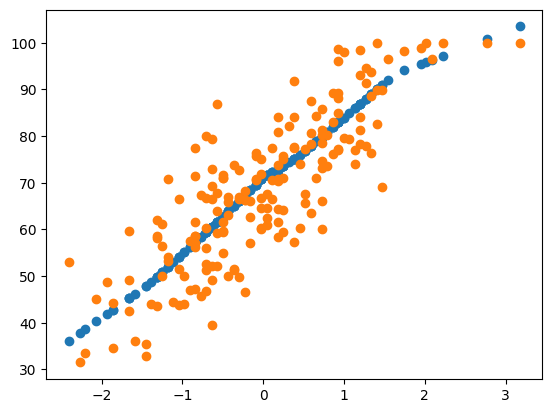

In [21]:
#plots predictions--remember, our model has never seen X_test
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

##Conclusion

This second model looks better. The general trend of the data has been fit very well, that being more studying correlates to a better score.

The train and test loss for both models is very similar, so it appears there's not much of a difference in the predictive power. However, I think that the real world accuracy of the second model is better because it mostly avoids the problem of going over 100 that the first one.

The losses on both are also realtively high because of the amount of variability in this data. Some students might just be naturally good at tests and not have to study much, while others might just struggle no matter how much they study, but the general trend still indicates that more studying is better for your grade. Neural networks aren't able to capture variance, just the mean, so the loss is bound to be at least somewhat high.

It's interesting to me that none of the variables outside of study hours seem to have much of a correlation with exam score. I would have thought that sleep would be pretty strong as well, but that seems to not be the case.

I would be interested to explore more variables in the future. Maybe making a data set where the student slept some number of hours the night before the test would result in a strong correlation there, rather than average sleep amount.